## Import Python Libraries

In [1]:
#libraries used for importing and exploring the data
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler

#libraries for data visualizaiton
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Default plot size and type
plt.rc("font", size=14)
plt.figure(figsize=(7,5))
plt.gray()

<Figure size 504x360 with 0 Axes>

## Import Data

In [2]:
df = pd.read_csv("syntheticcard.csv")

## Data Exploration

In [3]:
#shuffle the dataframe
df = df.sample(frac=1, random_state = 123).reset_index(drop=True)

In [4]:
#shape of the data (rows, columns)
df.shape

(24386900, 15)

In [5]:
df.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,423,0,2020,2,4,16:52,$2.70,Chip Transaction,6882551472640459815,Celina,OH,45822.0,5812,NaN,No
1,1110,0,2009,10,25,17:26,$120.00,Swipe Transaction,-4282466774399734331,Abilene,TX,79605.0,4829,NaN,No
2,1133,1,2018,6,15,12:49,$63.00,Chip Transaction,1799189980464955940,Greenfield,IN,46140.0,5499,NaN,No
3,172,0,2016,11,16,19:37,$-84.00,Chip Transaction,1799189980464955940,Acworth,GA,30101.0,5499,NaN,No
4,949,3,2004,12,20,12:29,$15.97,Swipe Transaction,97032797689821735,Rochester,MN,55906.0,5411,NaN,No


In [6]:
df.dtypes

User                int64
Card                int64
Year                int64
Month               int64
Day                 int64
Time               object
Amount             object
Use Chip           object
Merchant Name       int64
Merchant City      object
Merchant State     object
Zip               float64
MCC                 int64
Errors?            object
Is Fraud?          object
dtype: object

In [7]:
#description of the numeric columns in dataset
df.describe()

,User,Card,Year,Month,Day,Merchant Name,Zip,MCC
count,2.438690e+07,2.438690e+07,2.438690e+07,2.438690e+07,2.438690e+07,2.438690e+07,2.150876e+07,2.438690e+07
mean,1.001019e+03,1.351366e+00,2.011955e+03,6.525064e+00,1.571812e+01,-4.769230e+17,5.095644e+04,5.561171e+03
std,5.694612e+02,1.407154e+00,5.105921e+00,3.472355e+00,8.794073e+00,4.758940e+18,2.939707e+04,8.793154e+02
min,0.000000e+00,0.000000e+00,1.991000e+03,1.000000e+00,1.000000e+00,-9.222899e+18,5.010000e+02,1.711000e+03
25%,5.100000e+02,0.000000e+00,2.008000e+03,3.000000e+00,8.000000e+00,-4.500543e+18,2.837400e+04,5.300000e+03
50%,1.006000e+03,1.000000e+00,2.013000e+03,7.000000e+00,1.600000e+01,-7.946765e+17,4.674200e+04,5.499000e+03
75%,1.477000e+03,2.000000e+00,2.016000e+03,1.000000e+01,2.300000e+01,3.189517e+18,7.756400e+04,5.812000e+03
max,1.999000e+03,8.000000e+00,2.020000e+03,1.200000e+01,3.100000e+01,9.223292e+18,9.992800e+04,9.402000e+03


In [8]:
#check for null values
df.isnull().sum()

User                     0
Card                     0
Year                     0
Month                    0
Day                      0
Time                     0
Amount                   0
Use Chip                 0
Merchant Name            0
Merchant City            0
Merchant State     2720821
Zip                2878135
MCC                      0
Errors?           23998469
Is Fraud?                0
dtype: int64

In [9]:
#check the distribution of normal (0) and fraud (1) transactions
df["Is Fraud?"].value_counts()

No     24357143
Yes       29757
Name: Is Fraud?, dtype: int64

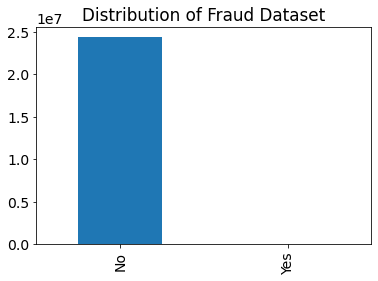

In [10]:
plt.figure()
plt.title("Distribution of Fraud Dataset")
ax=df["Is Fraud?"].value_counts().plot(kind="bar")
plt.show()

## Data Processing

From the exploration, the following steps are performed to adequately process the data before applying feature selection and machine learning algorithms.
1. Delete columns with high number of null values. These were the merchant state, zip code and errors columns.
2. Rename "Is Fraud?" to "Fraud".
3. Remove the $ symbol from the amount column and converted from object to float data type.
4. Encode object columns like the time, use chip, merchant name and fraud columns.
5. Balance the dataset using random undersampling and oversampling. Random Undersampling was performed on the majority class (non fraud) to reduce it to 1million records afterwhich random oversampling was performed on the minority cloass (fraud) to increase the number of records from 29k to 1million. 
6. Scale Amount column using Robust Scaler. 

### 1. Delete columns with Null Values

In [11]:
#drop columns with null values
df.drop(["Merchant State", "Zip", "Errors?"], axis = 1, inplace = True) 

### 2. Rename column

In [12]:
df.rename(columns={'Is Fraud?': 'Fraud'},inplace=True)

### 3. Remove $ from Amount & convert to float

In [13]:
#remove the $ symbol from the amount column and convert to numeric
df["Amount"] = df["Amount"].replace({'\$':''}, regex = True)

In [14]:
df["Amount"] = df["Amount"].astype(str).astype(float)

### 4. Encode Columns with Object Datatype

In [15]:
df["Time"] = df["Time"].astype('category').cat.codes
df["Use Chip"] = df["Use Chip"].astype('category').cat.codes
df["Merchant City"] = df["Merchant City"].astype('category').cat.codes
df["Merchant Name"] = df["Merchant Name"].astype('category').cat.codes
df["Fraud"] = df["Fraud"].astype('category').cat.codes

### 5. Balance the Dataset

#### A. Random Undersampling

In [16]:
#take a size of 1million random records from the "non fraud" records out of 24million records
non_fraud_df = df.query('Fraud == 0').sample(n = 1000000, random_state = 123)
fraud_df = df.query('Fraud == 1')

new_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = new_df.sample(frac=1, random_state=40)

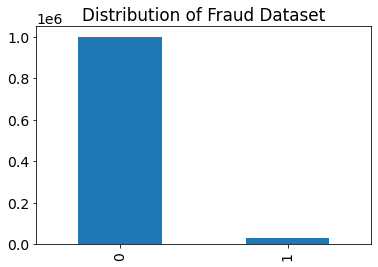

In [17]:
plt.figure()
plt.title("Distribution of Fraud Dataset")
ax=new_df["Fraud"].value_counts().plot(kind="bar")
plt.show()

#### B. Random Oversampling

In [18]:
#Oversampling the data
smote = SMOTE(random_state = 123)
X, y = smote.fit_resample(new_df[['User', 'Card', 'Year', 'Month', 'Day', 'Time', 'Amount', 'Use Chip',
       'Merchant Name', 'Merchant City', 'MCC']], new_df['Fraud'])


In [19]:
#Creating a new Oversampling Data Frame
new_df = pd.DataFrame(X, columns = ['User', 'Card', 'Year', 'Month', 'Day', 'Time', 'Amount', 'Use Chip',
       'Merchant Name', 'Merchant City', 'MCC'])
new_df["Fraud"] = y

In [20]:
new_df.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,MCC,Fraud
0,1386,1,2018,3,3,375,4.02,0,43293,3481,5499,0
1,539,1,2009,2,4,786,20.01,2,68812,10658,5812,0
2,1313,4,2014,7,21,370,7.28,2,37420,11102,5411,0
3,1477,3,2009,12,9,371,1.83,2,86438,773,5499,0
4,1158,2,2009,11,11,708,-61.00,2,43293,486,5499,0


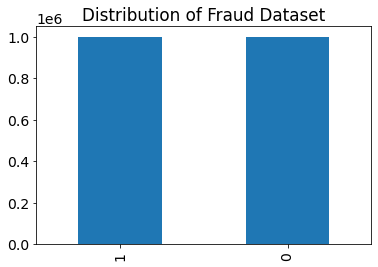

In [21]:
plt.figure()
plt.title("Distribution of Fraud Dataset")
ax=new_df["Fraud"].value_counts().plot(kind="bar")
plt.show()

### 6. Scale Amount using MinMax Scaler

In [22]:
scaler = MinMaxScaler()

new_df['scaled_amount'] = scaler.fit_transform(new_df['Amount'].values.reshape(-1,1))

new_df.drop(['Amount'], axis=1, inplace=True)

In [23]:
#Save processed dataframe which would be imported for model training and testing
new_df.to_csv(r'processed_data.csv', index = False, header = True)